In [1]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import pickle
with open('/kaggle/input/takeo-filtro/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-filtro/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)
    
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])
import numpy as np
Y = Y.astype(np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [25]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 

In [2]:
import numpy as np
Y = Y.astype(np.float32)

In [4]:
X = np.array(X)

In [5]:
X.shape

(10022, 224, 224, 3)

In [7]:
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])

2024-07-30 21:08:46.073807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 21:08:46.073911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 21:08:46.200940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
print(np.min(X))
print(np.max(X))
X.shape

0.0
255.0


(10022, 100, 100, 3)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [12]:
del X, Y

In [13]:
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [14]:
X_train_ = X_train
X_test_ = X_test

In [20]:
# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test))
print("X_test_normalized max:", np.max(X_test))
print("X_train_normalized min:", np.min(X_train))
print("X_train_normalized max:", np.max(X_train))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test.shape)
print("X_train_normalized shape:", X_train.shape)

X_test_normalized min: 2.0
X_test_normalized max: 255.0
X_train_normalized min: 2.0
X_train_normalized max: 255.0
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


In [16]:
import numpy as np

unique, counts = np.unique(Y_train, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no conjunto de treino")
print(ocorrencias)

unique, counts = np.unique(Y_test, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no conjunto de teste")
print(ocorrencias)

Distribuição no conjunto de treino
{0.0: 6330, 1.0: 6748}
Distribuição no conjunto de teste
{0.0: 1593, 1.0: 412}


In [17]:
import numpy as np
import cv2

def aplicar_filtro_sobel_clahe(imagens):
    imagens_transformadas = np.zeros_like(imagens)
    # Cria o objeto CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    for i in range(len(imagens)):
        # Converte a imagem para escala de cinza
        cinza = cv2.cvtColor(imagens[i], cv2.COLOR_RGB2GRAY)
        
        # Aplica o filtro Sobel
        sobelx = cv2.Sobel(cinza, cv2.CV_64F, 1, 0, ksize=3)  # Sobel horizontal
        sobely = cv2.Sobel(cinza, cv2.CV_64F, 0, 1, ksize=3)  # Sobel vertical
        
        # Combina os gradientes
        sobel = np.hypot(sobelx, sobely)
        
        # Normaliza para 0 a 255
        sobel_norm = np.uint8(255 * (sobel / np.max(sobel)))
        
        # Aplica CLAHE
        sobel_clahe = clahe.apply(sobel_norm)
        
        # Reconverte para formato RGB (opcional, apenas para manter o formato original)
        imagens_transformadas[i] = cv2.cvtColor(sobel_clahe, cv2.COLOR_GRAY2RGB)
        
        
    
    return imagens_transformadas



In [19]:
X_train = aplicar_filtro_sobel_clahe(X_train)
X_test = aplicar_filtro_sobel_clahe(X_test)

In [22]:
import numpy as np

# Supondo que X_test e X_train são seus arrays de dados
# Normaliza o X_test entre 0 e 255
X_test_normalized = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test)) * 255
X_test_normalized = X_test_normalized.astype(np.uint8)

# Normaliza o X_train entre 0 e 255
X_train_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train)) * 255
X_train_normalized = X_train_normalized.astype(np.uint8)

# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test_normalized))
print("X_test_normalized max:", np.max(X_test_normalized))
print("X_train_normalized min:", np.min(X_train_normalized))
print("X_train_normalized max:", np.max(X_train_normalized))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test_normalized.shape)
print("X_train_normalized shape:", X_train_normalized.shape)

X_train = X_train_normalized
X_test = X_test_normalized

X_test_normalized min: 0
X_test_normalized max: 255
X_train_normalized min: 0
X_train_normalized max: 255
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


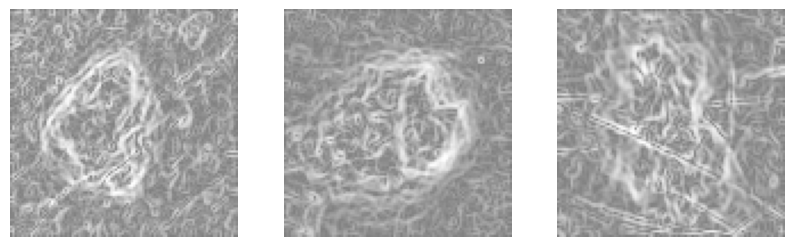

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img = ((X_train[i]/255) + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [26]:
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

def create_InceptionV3():
    base_model = InceptionV3(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1,
                           mode='auto', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 16,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
  8/654 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4604 - loss: 1.1010 

I0000 00:00:1722374118.360674     177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722374118.406260     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5828 - loss: 0.7591

W0000 00:00:1722374146.162975     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 58s 56ms/step - accuracy: 0.5829 - loss: 0.7591 - val_accuracy: 0.6586 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6607 - loss: 0.6271 - val_accuracy: 0.6800 - val_loss: 0.5991 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6778 - loss: 0.5999 - val_accuracy: 0.6743 - val_loss: 0.6088 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6994 - loss: 0.5808 - val_accuracy: 0.6728 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6974 - loss: 0.5861 - val_accuracy: 0.6735 - val_loss: 0.6070 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7097 - loss: 0.5736 - val_accuracy: 0.6636 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 7/30
652/654 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7091 - loss: 0.5649


W0000 00:00:1722374257.718007     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step
Precisão Classe 1: 0.6228248737896998
Recall Classe 1: 0.658954680367384
F1-Score Classe 1: 0.6305298708112007
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4536 - loss: 0.9376 

W0000 00:00:1722374292.136456     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5833 - loss: 0.7591

W0000 00:00:1722374317.399117     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.5833 - loss: 0.7590 - val_accuracy: 0.6732 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6482 - loss: 0.6371 - val_accuracy: 0.6606 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6826 - loss: 0.6046 - val_accuracy: 0.6521 - val_loss: 0.6300 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6953 - loss: 0.5882 - val_accuracy: 0.6479 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7023 - loss: 0.5763 - val_accuracy: 0.6716 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7218 - loss: 0.5572 - val_accuracy: 0.6667 - val_loss: 0.6128 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7178 - loss: 0.5621

W0000 00:00:1722374453.943797     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
Precisão Classe 1: 0.6159056503681084
Recall Classe 1: 0.6637869562832538
F1-Score Classe 1: 0.6167926137198977
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5647 - loss: 0.9210 

W0000 00:00:1722374483.351957     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6048 - loss: 0.7416

W0000 00:00:1722374507.248691     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.6049 - loss: 0.7415 - val_accuracy: 0.6808 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6589 - loss: 0.6277 - val_accuracy: 0.6843 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6783 - loss: 0.6001 - val_accuracy: 0.6640 - val_loss: 0.6100 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6935 - loss: 0.5878 - val_accuracy: 0.6644 - val_loss: 0.6048 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6965 - loss: 0.5754 - val_accuracy: 0.6823 - val_loss: 0.6260 - learning_rate: 0.0010
Epoch 6/30
651/654 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7128 - loss: 0.5660
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7128 - loss: 0.5660 

W0000 00:00:1722374601.352272     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Precisão Classe 1: 0.6053175689609027
Recall Classe 1: 0.64629462027438
F1-Score Classe 1: 0.606753866472461
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5326 - loss: 0.8513 

W0000 00:00:1722374629.922555     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6030 - loss: 0.7396

W0000 00:00:1722374653.502780     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.6030 - loss: 0.7395 - val_accuracy: 0.6544 - val_loss: 0.6302 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6601 - loss: 0.6270 - val_accuracy: 0.6850 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6767 - loss: 0.5984 - val_accuracy: 0.6854 - val_loss: 0.6124 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6978 - loss: 0.5874 - val_accuracy: 0.6774 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7054 - loss: 0.5766 - val_accuracy: 0.6835 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7107 - loss: 0.5700 - val_accuracy: 0.6682 - val_loss: 0.6116 - learning_rate: 0.0010
Epoch 7/30
652/654 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7202 - loss: 0.5593


W0000 00:00:1722374755.248765     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.6029308646005235
Recall Classe 1: 0.6556666300989158
F1-Score Classe 1: 0.5833362865553364
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4714 - loss: 0.8722 

W0000 00:00:1722374783.944283     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5889 - loss: 0.7518

W0000 00:00:1722374807.788970     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5890 - loss: 0.7517 - val_accuracy: 0.6823 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6711 - loss: 0.6217 - val_accuracy: 0.6793 - val_loss: 0.6047 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6876 - loss: 0.5976 - val_accuracy: 0.6537 - val_loss: 0.6261 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7054 - loss: 0.5753 - val_accuracy: 0.6644 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7117 - loss: 0.5686 - val_accuracy: 0.6865 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7102 - loss: 0.5735 - val_accuracy: 0.6663 - val_loss: 0.6179 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7264 - loss: 0.5528

W0000 00:00:1722374945.512141     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Precisão Classe 1: 0.6059882364871717
Recall Classe 1: 0.6592449368901565
F1-Score Classe 1: 0.5903873335585456
Acurácia média: 0.6745137157107233 ± 0.03123102654091976
Precisão média: 0.6105934388412811 ± 0.0075575833163155385
Recall médio: 0.656789564782818 ± 0.005849528323376186
F1-Score médio: 0.6055599942234882 ± 0.017176697136973364


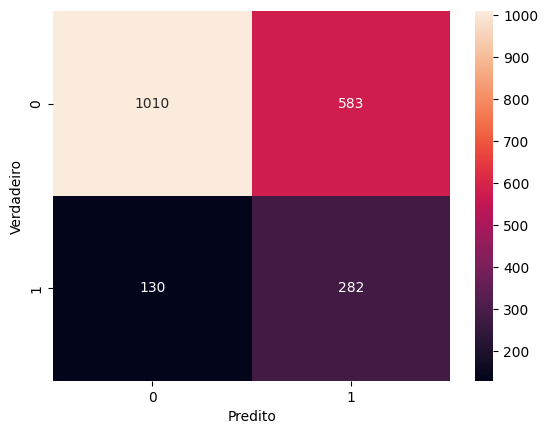

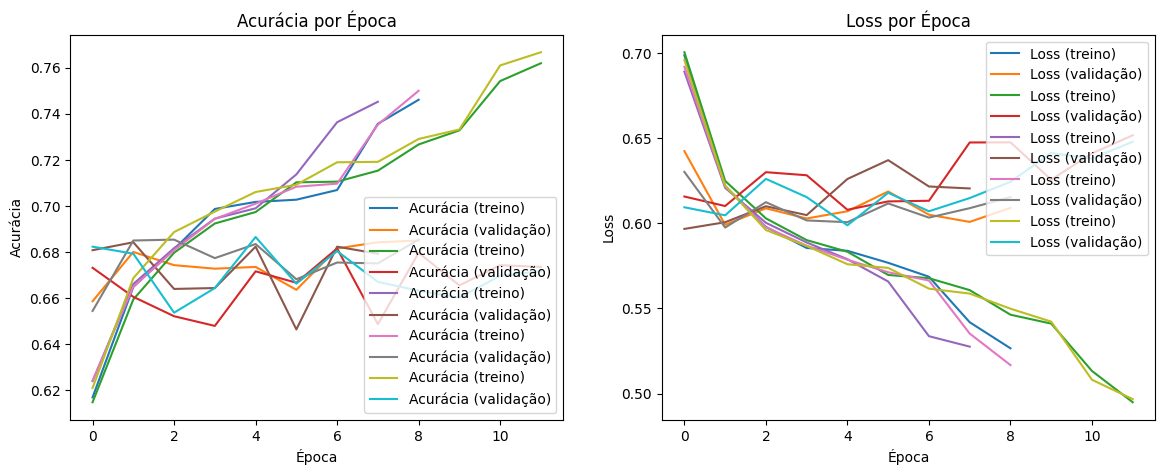

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []

for i in range(5):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, X_train, Y_train, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [47]:
del X_train, X_test, accuracies, precisions, recalls, f1_scores, historys

NameError: name 'accuracies' is not defined

In [89]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import pickle
with open('/kaggle/input/takeo-filtro/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-filtro/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)
    
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])
import numpy as np
Y = Y.astype(np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [90]:
# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test))
print("X_test_normalized max:", np.max(X_test))
print("X_train_normalized min:", np.min(X_train))
print("X_train_normalized max:", np.max(X_train))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test.shape)
print("X_train_normalized shape:", X_train.shape)

X_test_normalized min: 0.0
X_test_normalized max: 255.0
X_train_normalized min: 0.0
X_train_normalized max: 255.0
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


In [91]:
import numpy as np
import cv2

def aplicar_filtro_gabor(imagens, ksize=(15, 31), sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    imagens_transformadas = np.zeros_like(imagens)
    # Cria o kernel de Gabor
    gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
    
    for i in range(len(imagens)):
        # Converte a imagem para escala de cinza
        cinza = cv2.cvtColor(imagens[i], cv2.COLOR_RGB2GRAY)
        
        # Aplica o filtro de Gabor
        gabor = cv2.filter2D(cinza, cv2.CV_8UC3, gabor_kernel)
        
        # Reconverte para formato RGB (opcional, apenas para manter o formato original)
        imagens_transformadas[i] = cv2.cvtColor(gabor, cv2.COLOR_GRAY2RGB)
    
    return imagens_transformadas

# Suponha que 'imagens' seja o seu array de imagens de entrada
# imagens = np.array([...])  # Array de imagens 224x224x3 com valores entre 0 e 255
# imagens_filtradas = aplicar_filtro_gabor(imagens)


In [92]:
X_train = aplicar_filtro_gabor(X_train)
X_test = aplicar_filtro_gabor(X_test)

In [93]:
print(np.min(X_test))
print(np.max(X_test))
X_test.shape

0.0
255.0


(2005, 100, 100, 3)

In [97]:
# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test))
print("X_test_normalized max:", np.max(X_test))
print("X_train_normalized min:", np.min(X_train))
print("X_train_normalized max:", np.max(X_train))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test.shape)
print("X_train_normalized shape:", X_train.shape)

X_test_normalized min: -1.0
X_test_normalized max: 1.0
X_train_normalized min: -1.0
X_train_normalized max: 1.0
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


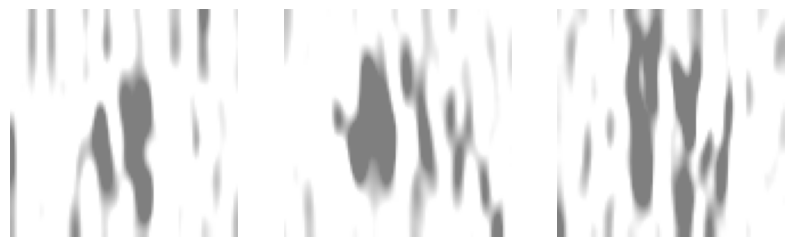

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img = ((X_train[i]/255) + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [96]:
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.4449 - loss: 0.8992 

W0000 00:00:1722375856.568757     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6017 - loss: 0.7354

W0000 00:00:1722375879.784016     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.6017 - loss: 0.7354 - val_accuracy: 0.6533 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6624 - loss: 0.6314 - val_accuracy: 0.6560 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6769 - loss: 0.6041 - val_accuracy: 0.6590 - val_loss: 0.6226 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6823 - loss: 0.5976 - val_accuracy: 0.6709 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6942 - loss: 0.5900 - val_accuracy: 0.6644 - val_loss: 0.6143 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7018 - loss: 0.5810 - val_accuracy: 0.6541 - val_loss: 0.6256 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7011 - loss: 0.5806

W0000 00:00:1722376017.240286     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step
Precisão Classe 1: 0.6173892483822798
Recall Classe 1: 0.6796657402836439
F1-Score Classe 1: 0.585163610898905
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5501 - loss: 0.8569 

W0000 00:00:1722376046.274474     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5973 - loss: 0.7488

W0000 00:00:1722376070.186861     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5974 - loss: 0.7487 - val_accuracy: 0.6590 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6561 - loss: 0.6282 - val_accuracy: 0.6617 - val_loss: 0.6172 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6680 - loss: 0.6117 - val_accuracy: 0.6651 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6834 - loss: 0.5959 - val_accuracy: 0.6632 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6966 - loss: 0.5810 - val_accuracy: 0.6506 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6989 - loss: 0.5791 - val_accuracy: 0.6571 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 7/30
652/654 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6992 - loss: 0.5793


W0000 00:00:1722376194.193758     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step
Precisão Classe 1: 0.6170995108675978
Recall Classe 1: 0.6675740039858848
F1-Score Classe 1: 0.6163162777628401
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4822 - loss: 0.9478 

W0000 00:00:1722376223.290435     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5937 - loss: 0.7629

W0000 00:00:1722376247.169014     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5938 - loss: 0.7628 - val_accuracy: 0.6372 - val_loss: 0.6360 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6401 - loss: 0.6437 - val_accuracy: 0.6594 - val_loss: 0.6257 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6764 - loss: 0.6103 - val_accuracy: 0.6690 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6839 - loss: 0.5990 - val_accuracy: 0.6544 - val_loss: 0.6331 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6935 - loss: 0.5897 - val_accuracy: 0.6766 - val_loss: 0.6159 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7023 - loss: 0.5808 - val_accuracy: 0.6720 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7031 - loss: 0.5742

W0000 00:00:1722376384.615103     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.6177048303038779
Recall Classe 1: 0.6769467756385643
F1-Score Classe 1: 0.6033566479212837
Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5702 - loss: 0.8552 

W0000 00:00:1722376413.700944     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5976 - loss: 0.7454

W0000 00:00:1722376437.368900     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.5976 - loss: 0.7453 - val_accuracy: 0.6606 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6683 - loss: 0.6275 - val_accuracy: 0.6544 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6788 - loss: 0.6066 - val_accuracy: 0.6732 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6879 - loss: 0.5983 - val_accuracy: 0.6670 - val_loss: 0.6211 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6935 - loss: 0.5890 - val_accuracy: 0.6548 - val_loss: 0.6201 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7040 - loss: 0.5817 - val_accuracy: 0.6716 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6987 - loss: 0.5755

W0000 00:00:1722376587.218480     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step
Precisão Classe 1: 0.6169831383867538
Recall Classe 1: 0.676005156052877
F1-Score Classe 1: 0.6021297596771906
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4864 - loss: 0.9396 

W0000 00:00:1722376616.800452     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5971 - loss: 0.7648

W0000 00:00:1722376640.675820     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5971 - loss: 0.7647 - val_accuracy: 0.6181 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6476 - loss: 0.6378 - val_accuracy: 0.6678 - val_loss: 0.6167 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6749 - loss: 0.6109 - val_accuracy: 0.6648 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6828 - loss: 0.6032 - val_accuracy: 0.6418 - val_loss: 0.6296 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6957 - loss: 0.5883 - val_accuracy: 0.6563 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6986 - loss: 0.5758 - val_accuracy: 0.6560 - val_loss: 0.6248 - learning_rate: 0.0010
Epoch 7/30
652/654 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7037 - loss: 0.5782


W0000 00:00:1722376752.790454     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step
Precisão Classe 1: 0.6137517842460776
Recall Classe 1: 0.6741203932252147
F1-Score Classe 1: 0.5733793107928999
Acurácia média: 0.6451870324189526 ± 0.026768874801347847
Precisão média: 0.6165857024373174 ± 0.0014388314716428398
Recall médio: 0.6748624138372369 ± 0.004059405907049539
F1-Score médio: 0.596069121410624 ± 0.015056854814882314


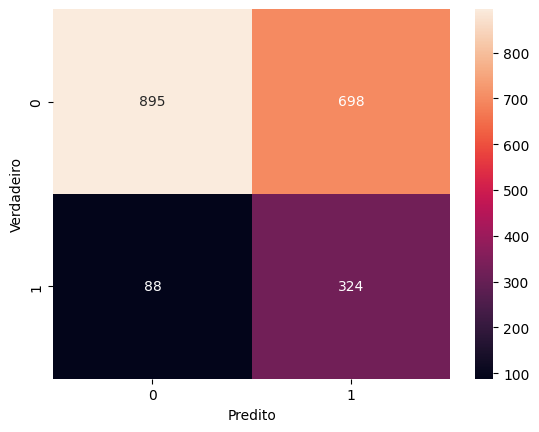

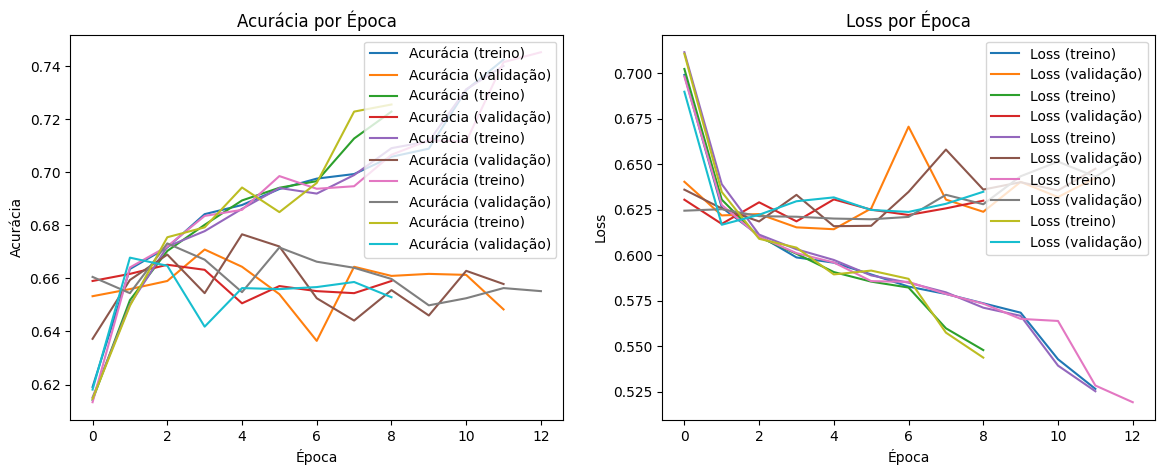

In [98]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []

for i in range(5):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, X_train, Y_train, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [99]:
del X_train, X_test, accuracies, precisions, recalls, f1_scores, historys

In [109]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import pickle
with open('/kaggle/input/takeo-filtro/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-filtro/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)
    
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])
import numpy as np
Y = Y.astype(np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [110]:
# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test))
print("X_test_normalized max:", np.max(X_test))
print("X_train_normalized min:", np.min(X_train))
print("X_train_normalized max:", np.max(X_train))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test.shape)
print("X_train_normalized shape:", X_train.shape)

X_test_normalized min: 0.0
X_test_normalized max: 255.0
X_train_normalized min: 0.0
X_train_normalized max: 255.0
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


In [111]:
import numpy as np
import cv2
from scipy.signal import wiener

def aplicar_filtro_wiener(imagens):
    imagens_transformadas = np.zeros_like(imagens)
    
    for i in range(len(imagens)):
        # Converte a imagem para escala de cinza para simplificar o processamento
        cinza = cv2.cvtColor(imagens[i], cv2.COLOR_RGB2GRAY)
        
        # Aplica o filtro de Wiener
        filtrada = wiener(cinza, (3, 3))  # Ajuste o tamanho do kernel conforme necessário
        
        # Reconverte para formato RGB (opcional, apenas para manter o formato original)
        imagens_transformadas[i] = cv2.cvtColor(filtrada.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    return imagens_transformadas

# Suponha que 'imagens' seja o seu array de imagens de entrada
# imagens = np.array([...])  # Array de imagens 224x224x3 com valores entre 0 e 255
# imagens_filtradas = aplicar_filtro_wiener(imagens)


In [112]:
X_train = aplicar_filtro_wiener(X_train)
X_test = aplicar_filtro_wiener(X_test)

In [117]:
print(np.min(X_test))
print(np.max(X_test))
X_test.shape

-1.0078431
-0.9922184


(2005, 100, 100, 3)

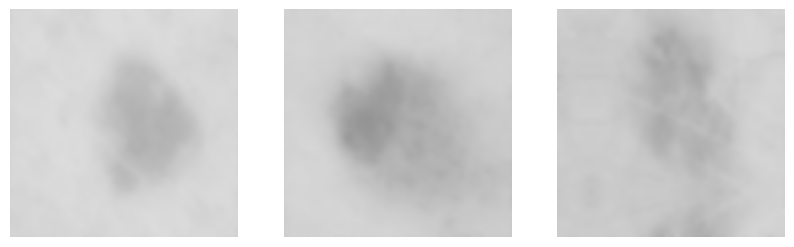

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img = ((X_train[i]/255) + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [116]:
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5723 - loss: 0.8462

W0000 00:00:1722377241.460413     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6333 - loss: 0.7054

W0000 00:00:1722377265.562710     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.6333 - loss: 0.7053 - val_accuracy: 0.6751 - val_loss: 0.6177 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6831 - loss: 0.6057 - val_accuracy: 0.6816 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6970 - loss: 0.5801 - val_accuracy: 0.6288 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7097 - loss: 0.5758 - val_accuracy: 0.6544 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7141 - loss: 0.5650 - val_accuracy: 0.7018 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7254 - loss: 0.5621 - val_accuracy: 0.6617 - val_loss: 0.6198 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7159 - loss: 0.5597

W0000 00:00:1722377544.301672     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.6485412211782903
Recall Classe 1: 0.7241725022702479
F1-Score Classe 1: 0.636025453378343
Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6025 - loss: 0.8900 

W0000 00:00:1722377573.881857     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6266 - loss: 0.7253

W0000 00:00:1722377597.900970     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.6267 - loss: 0.7252 - val_accuracy: 0.6835 - val_loss: 0.5914 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6816 - loss: 0.6147 - val_accuracy: 0.6235 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7103 - loss: 0.5822 - val_accuracy: 0.6873 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7114 - loss: 0.5755 - val_accuracy: 0.7076 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7051 - loss: 0.5699 - val_accuracy: 0.7087 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7132 - loss: 0.5664 - val_accuracy: 0.7060 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7191 - loss: 0.5522

W0000 00:00:1722377851.926285     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.6551060606060606
Recall Classe 1: 0.7339650412301391
F1-Score Classe 1: 0.6437236449128274
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5923 - loss: 0.8186 

W0000 00:00:1722377890.593223     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6420 - loss: 0.7051

W0000 00:00:1722377913.864746     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.6420 - loss: 0.7051 - val_accuracy: 0.6724 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6758 - loss: 0.6067 - val_accuracy: 0.6617 - val_loss: 0.6505 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7058 - loss: 0.5836 - val_accuracy: 0.6686 - val_loss: 0.6209 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7148 - loss: 0.5650 - val_accuracy: 0.6980 - val_loss: 0.5878 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7214 - loss: 0.5588 - val_accuracy: 0.7217 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7108 - loss: 0.5653 - val_accuracy: 0.7141 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7195 - loss: 0.5590

W0000 00:00:1722378064.217283     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step
Precisão Classe 1: 0.6479862568806598
Recall Classe 1: 0.7230008105851449
F1-Score Classe 1: 0.6362797267263292
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5844 - loss: 0.8854 

W0000 00:00:1722378093.889409     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6217 - loss: 0.7370

W0000 00:00:1722378117.817060     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.6217 - loss: 0.7369 - val_accuracy: 0.6693 - val_loss: 0.6316 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6756 - loss: 0.6153 - val_accuracy: 0.6835 - val_loss: 0.5958 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6835 - loss: 0.5958 - val_accuracy: 0.5959 - val_loss: 0.7295 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7147 - loss: 0.5683 - val_accuracy: 0.6739 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7168 - loss: 0.5677 - val_accuracy: 0.6999 - val_loss: 0.5725 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7232 - loss: 0.5608 - val_accuracy: 0.7007 - val_loss: 0.5660 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7229 - loss: 0.5549

W0000 00:00:1722378347.896776     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Precisão Classe 1: 0.6581172233003376
Recall Classe 1: 0.736371656336277
F1-Score Classe 1: 0.6516565656565657
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5188 - loss: 0.9186 

W0000 00:00:1722378377.619589     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6276 - loss: 0.7238

W0000 00:00:1722378401.165890     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.6276 - loss: 0.7237 - val_accuracy: 0.6177 - val_loss: 0.6780 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6866 - loss: 0.6133 - val_accuracy: 0.6778 - val_loss: 0.6026 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6990 - loss: 0.5830 - val_accuracy: 0.6479 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7044 - loss: 0.5820 - val_accuracy: 0.6705 - val_loss: 0.6228 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7057 - loss: 0.5843 - val_accuracy: 0.6762 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7216 - loss: 0.5604 - val_accuracy: 0.5485 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 7/30
652/654 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7250 - loss: 0.5566


W0000 00:00:1722378585.470468     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Precisão Classe 1: 0.6582773852685714
Recall Classe 1: 0.7333380566678247
F1-Score Classe 1: 0.6567435129643806
Acurácia média: 0.6924688279301746 ± 0.010535857098462538
Precisão média: 0.6536056294467839 ± 0.004509027708241589
Recall médio: 0.7301696134179266 ± 0.005482092984244479
F1-Score médio: 0.6448857807276893 ± 0.008250690494913176


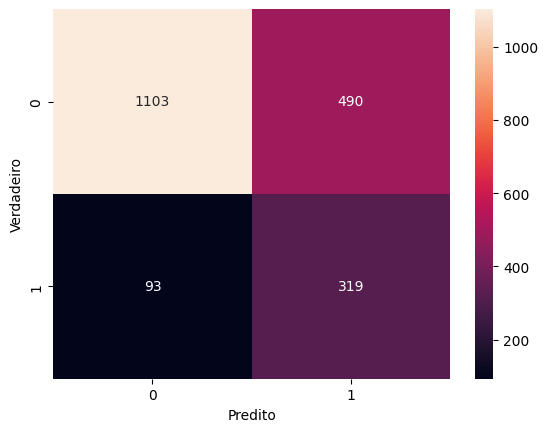

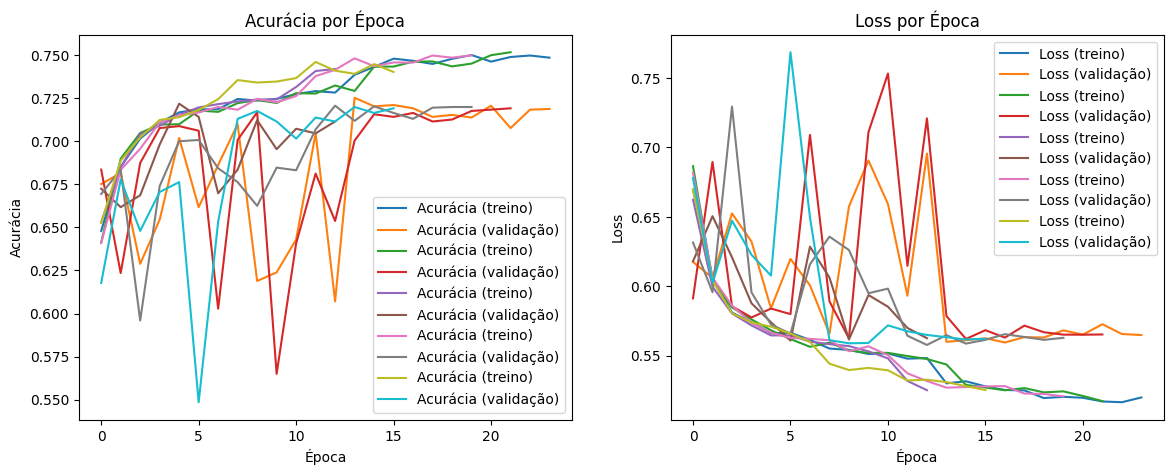

In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []

for i in range(5):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, X_train, Y_train, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [119]:
del X_train, X_test, accuracies, precisions, recalls, f1_scores, historys

In [120]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import pickle
with open('/kaggle/input/takeo-filtro/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-filtro/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)
    
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])
import numpy as np
Y = Y.astype(np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [121]:
import numpy as np
import cv2
import pywt

def aplicar_wavelet_diagonal(imagens, wavelet='db1'):
    imagens_transformadas = np.zeros_like(imagens)
    
    for i in range(len(imagens)):
        # Converte a imagem para escala de cinza
        cinza = cv2.cvtColor(imagens[i], cv2.COLOR_RGB2GRAY)
        
        # Aplica a Transformada de Wavelet
        coeffs = pywt.wavedec2(cinza, wavelet=wavelet, level=1)
        cA, (cH, cV, cD) = coeffs  # cA = coeficiente de aproximação, cH = horizontal, cV = vertical, cD = diagonal
        
        # Normaliza o componente diagonal para o intervalo de 0 a 255
        cD_normalized = cv2.normalize(cD, None, 0, 255, cv2.NORM_MINMAX)
        
        # Redimensiona o componente diagonal para o tamanho original da imagem
        cD_resized = cv2.resize(cD_normalized, (imagens[i].shape[1], imagens[i].shape[0]), interpolation=cv2.INTER_LINEAR)
        
        # Convertendo de volta para 8-bit para compatibilidade com as imagens originais
        cD_resized = cD_resized.astype(np.uint8)
        
        # Reconverte para formato RGB (opcional, apenas para manter o formato original)
        imagens_transformadas[i] = cv2.cvtColor(cD_resized, cv2.COLOR_GRAY2RGB)
    
    return imagens_transformadas


In [123]:
X_train = aplicar_wavelet_diagonal(X_train)
X_test = aplicar_wavelet_diagonal(X_test)

In [127]:
print(np.min(X_test))
print(np.max(X_test))
X_test.shape

-1.0078431
-0.99215686


(2005, 100, 100, 3)

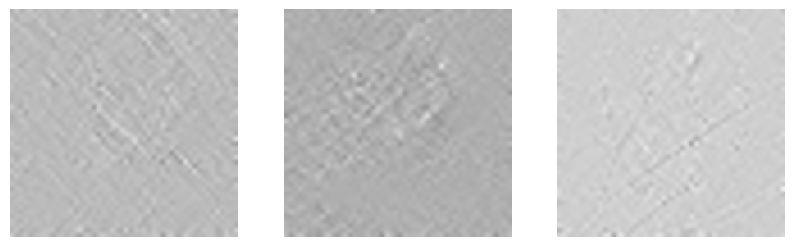

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img = ((X_train[i]/255) + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

In [126]:
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4591 - loss: 1.0372

W0000 00:00:1722378807.068273     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5140 - loss: 0.8257

W0000 00:00:1722378831.183238     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5140 - loss: 0.8257 - val_accuracy: 0.4996 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5139 - loss: 0.7204 - val_accuracy: 0.5344 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5183 - loss: 0.7037 - val_accuracy: 0.5432 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5472 - loss: 0.6928 - val_accuracy: 0.5130 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5536 - loss: 0.6864 - val_accuracy: 0.5424 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5385 - loss: 0.6866 - val_accuracy: 0.5237 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5569 - loss: 0.6856

W0000 00:00:1722378947.062756     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step
Precisão Classe 1: 0.522861718517987
Recall Classe 1: 0.5349534370638533
F1-Score Classe 1: 0.471292834186842
Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4456 - loss: 0.9882 

W0000 00:00:1722378977.074258     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5078 - loss: 0.8247

W0000 00:00:1722379000.835981     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.5078 - loss: 0.8246 - val_accuracy: 0.5199 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5172 - loss: 0.7157 - val_accuracy: 0.5229 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5298 - loss: 0.7002 - val_accuracy: 0.5210 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5420 - loss: 0.6952 - val_accuracy: 0.5222 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5380 - loss: 0.6906 - val_accuracy: 0.5019 - val_loss: 0.7540 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5542 - loss: 0.6877 - val_accuracy: 0.5057 - val_loss: 0.7042 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5436 - loss: 0.6879

W0000 00:00:1722379253.405010     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.5233582664835826
Recall Classe 1: 0.5354570054668788
F1-Score Classe 1: 0.49143607750644747
Epoch 1/30
 13/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5702 - loss: 0.8401 

W0000 00:00:1722379283.429922     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5064 - loss: 0.8202

W0000 00:00:1722379307.416784     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5064 - loss: 0.8202 - val_accuracy: 0.5126 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5225 - loss: 0.7145 - val_accuracy: 0.5138 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5376 - loss: 0.6976 - val_accuracy: 0.5122 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5367 - loss: 0.6937 - val_accuracy: 0.5420 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5380 - loss: 0.6904 - val_accuracy: 0.5203 - val_loss: 0.7023 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5358 - loss: 0.6904 - val_accuracy: 0.5524 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5643 - loss: 0.6835

W0000 00:00:1722379516.780068     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.5215614281989064
Recall Classe 1: 0.5330077279846903
F1-Score Classe 1: 0.4735620635303853
Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4785 - loss: 0.9880 

W0000 00:00:1722379547.156413     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5089 - loss: 0.8399

W0000 00:00:1722379571.001302     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5090 - loss: 0.8398 - val_accuracy: 0.5157 - val_loss: 0.7409 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5297 - loss: 0.7166 - val_accuracy: 0.5069 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5279 - loss: 0.7005 - val_accuracy: 0.5371 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5352 - loss: 0.6939 - val_accuracy: 0.5275 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5275 - loss: 0.6973 - val_accuracy: 0.5153 - val_loss: 0.6998 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5420 - loss: 0.6884 - val_accuracy: 0.5038 - val_loss: 0.7007 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5539 - loss: 0.6854

W0000 00:00:1722379754.218716     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step
Precisão Classe 1: 0.5298111099827358
Recall Classe 1: 0.5447269303201507
F1-Score Classe 1: 0.5049007447018666
Epoch 1/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4542 - loss: 1.1285 

W0000 00:00:1722379784.726260     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5006 - loss: 0.8487

W0000 00:00:1722379808.648733     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5006 - loss: 0.8486 - val_accuracy: 0.5069 - val_loss: 0.7133 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5275 - loss: 0.7179 - val_accuracy: 0.5130 - val_loss: 0.7009 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5303 - loss: 0.7011 - val_accuracy: 0.5321 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5381 - loss: 0.6959 - val_accuracy: 0.5180 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5452 - loss: 0.6914 - val_accuracy: 0.5099 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5360 - loss: 0.6889 - val_accuracy: 0.5443 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5418 - loss: 0.6878

W0000 00:00:1722379968.475057     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Precisão Classe 1: 0.5244767333489667
Recall Classe 1: 0.5372145429945332
F1-Score Classe 1: 0.49149365952193924
Acurácia média: 0.5397506234413966 ± 0.02250343997959766
Precisão média: 0.5244138513064358 ± 0.0028563630184467947
Recall médio: 0.5370719287660213 ± 0.004055443254618102
F1-Score médio: 0.48653707588949613 ± 0.012542169837844981


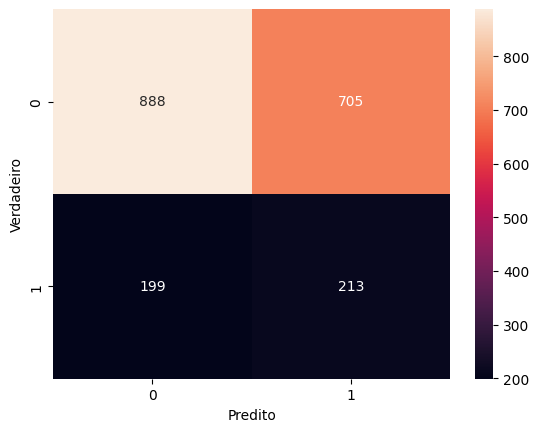

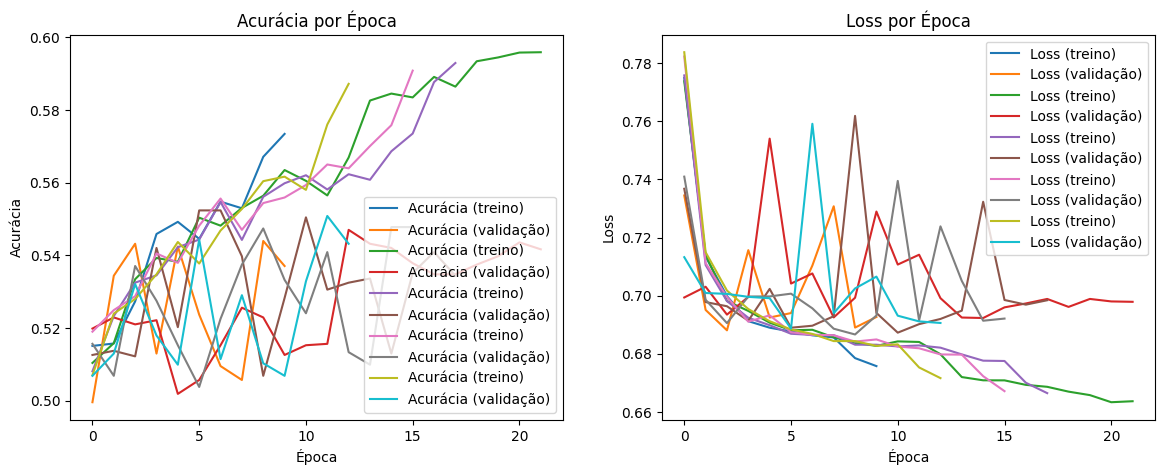

In [128]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []

for i in range(5):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, X_train, Y_train, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [129]:
del X_train, X_test, accuracies, precisions, recalls, f1_scores, historys

In [130]:
del X, Y 

In [ ]:
import gc

# Força a coleta de lixo
gc.collect()

In [22]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import pickle
with open('/kaggle/input/takeo-filtro/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-filtro/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)
    
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])
import numpy as np
Y = Y.astype(np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [29]:
import numpy as np
# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test))
print("X_test_normalized max:", np.max(X_test))
print("X_train_normalized min:", np.min(X_train))
print("X_train_normalized max:", np.max(X_train))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test.shape)
print("X_train_normalized shape:", X_train.shape)

X_test_normalized min: -1.0
X_test_normalized max: 1.0
X_train_normalized min: -1.0
X_train_normalized max: 1.0
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


In [24]:
import numpy as np
import cv2

def aplicar_filtro_gaussiano(imagens, tamanho_kernel=(3, 3), sigma=0):
    imagens_transformadas = np.zeros_like(imagens)
    
    for i in range(len(imagens)):
        # Aplica o filtro Gaussiano
        filtrada = cv2.GaussianBlur(imagens[i], tamanho_kernel, sigma)
        
        # Armazena a imagem filtrada no array de imagens transformadas
        imagens_transformadas[i] = filtrada
    
    return imagens_transformadas


In [25]:
X_train = aplicar_filtro_gaussiano(X_train)
X_test = aplicar_filtro_gaussiano(X_test)

In [21]:
print(np.min(X_test))
print(np.max(X_test))
X_test.shape

-1.0078431
-0.99215686


(2005, 100, 100, 3)

In [18]:
# Supondo que X_test e X_train são seus arrays de dados
# Normaliza o X_test entre 0 e 255
X_test_normalized = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test)) * 255
X_test_normalized = X_test_normalized.astype(np.uint8)

# Normaliza o X_train entre 0 e 255
X_train_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train)) * 255
X_train_normalized = X_train_normalized.astype(np.uint8)

# Verifica os valores mínimos e máximos após a normalização
print("X_test_normalized min:", np.min(X_test_normalized))
print("X_test_normalized max:", np.max(X_test_normalized))
print("X_train_normalized min:", np.min(X_train_normalized))
print("X_train_normalized max:", np.max(X_train_normalized))

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test_normalized.shape)
print("X_train_normalized shape:", X_train_normalized.shape)

X_test = X_test_normalized
X_train = X_train_normalized

# Verifica as formas dos arrays
print("X_test_normalized shape:", X_test.shape)
print("X_train_normalized shape:", X_train.shape)

X_test_normalized min: 0
X_test_normalized max: 255
X_train_normalized min: 0
X_train_normalized max: 255
X_test_normalized shape: (2005, 100, 100, 3)
X_train_normalized shape: (13078, 100, 100, 3)


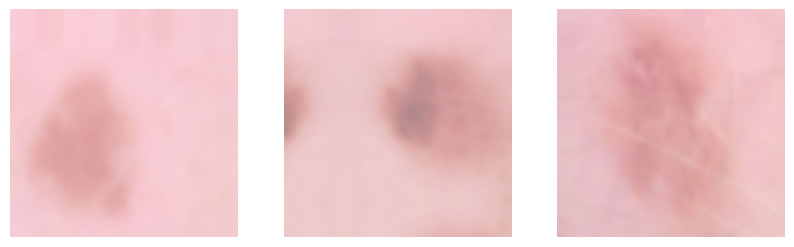

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img = ((X_train[i]/255) + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [28]:
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
  7/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4763 - loss: 0.9177 

I0000 00:00:1722380619.832717     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722380619.882269     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6376 - loss: 0.6921

W0000 00:00:1722380651.801940     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 66s 63ms/step - accuracy: 0.6377 - loss: 0.6920 - val_accuracy: 0.6957 - val_loss: 0.5672 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7189 - loss: 0.5526 - val_accuracy: 0.6927 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7311 - loss: 0.5340 - val_accuracy: 0.7190 - val_loss: 0.5541 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7384 - loss: 0.5171 - val_accuracy: 0.7236 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7634 - loss: 0.5016 - val_accuracy: 0.7301 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7830 - loss: 0.4671 - val_accuracy: 0.7282 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7681 - loss: 0.4786

W0000 00:00:1722380846.874870     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6355 - loss: 0.7040

W0000 00:00:1722380873.561663     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.6356 - loss: 0.7039 - val_accuracy: 0.6946 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.7151 - loss: 0.5571 - val_accuracy: 0.6946 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7480 - loss: 0.5139 - val_accuracy: 0.7102 - val_loss: 0.5779 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7486 - loss: 0.5045 - val_accuracy: 0.6999 - val_loss: 0.5679 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7651 - loss: 0.4874 - val_accuracy: 0.7122 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7524 - loss: 0.4921 - val_accuracy: 0.7290 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7728 - loss: 0.4818

W0000 00:00:1722381202.380901     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.6275 - loss: 0.7191 - val_accuracy: 0.7263 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7137 - loss: 0.5549 - val_accuracy: 0.7148 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7390 - loss: 0.5260 - val_accuracy: 0.7294 - val_loss: 0.5318 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7558 - loss: 0.4994 - val_accuracy: 0.7236 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7629 - loss: 0.4958 - val_accuracy: 0.7206 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7696 - loss: 0.4861 - val_accuracy: 0.7286 - val_loss: 0.5515 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7766 - loss: 0.4784

W0000 00:00:1722381364.246748     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6381 - loss: 0.7151

W0000 00:00:1722381391.793326     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.6381 - loss: 0.7150 - val_accuracy: 0.7030 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7174 - loss: 0.5612 - val_accuracy: 0.7221 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7435 - loss: 0.5182 - val_accuracy: 0.7179 - val_loss: 0.5565 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7623 - loss: 0.5012 - val_accuracy: 0.7160 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7641 - loss: 0.4945 - val_accuracy: 0.7232 - val_loss: 0.5524 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7737 - loss: 0.4811 - val_accuracy: 0.7232 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 7/30
 12/654 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5331 - loss: 0.8152

W0000 00:00:1722381565.836142     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6429 - loss: 0.6981

W0000 00:00:1722381592.867981     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.6429 - loss: 0.6981 - val_accuracy: 0.7083 - val_loss: 0.5554 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7087 - loss: 0.5597 - val_accuracy: 0.6999 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7363 - loss: 0.5275 - val_accuracy: 0.7183 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7550 - loss: 0.4996 - val_accuracy: 0.7278 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7658 - loss: 0.4872 - val_accuracy: 0.7167 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7689 - loss: 0.4779 - val_accuracy: 0.7175 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7770 - loss: 0.4764

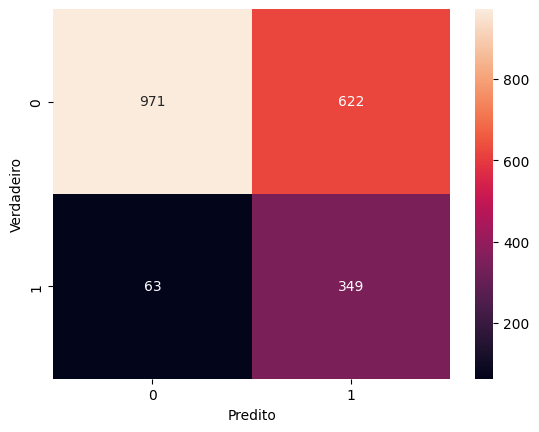

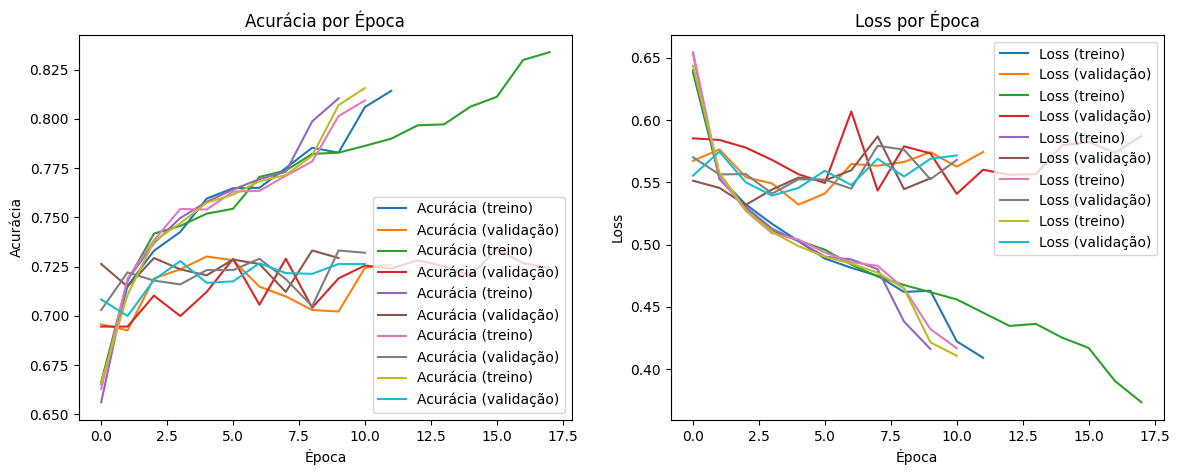

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []

for i in range(5):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, X_train, Y_train, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
del X_train, X_test, accuracies, precisions, recalls, f1_scores, historys

In [49]:
from tensorflow.keras.applications.inception_v3 import preprocess_input 
import pickle
with open('/kaggle/input/takeo-filtro/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-filtro/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)
    
from tensorflow.image import resize
X = np.array([resize(image, [100, 100]) for image in X])
import numpy as np
Y = Y.astype(np.float32)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [50]:
print(np.min(X_test))
print(np.max(X_test))
X_test.shape

0.0
255.0


(2005, 100, 100, 3)

In [53]:
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)

In [54]:
print(np.min(X_test))
print(np.max(X_test))
X_test.shape

-1.0
1.0


(2005, 100, 100, 3)

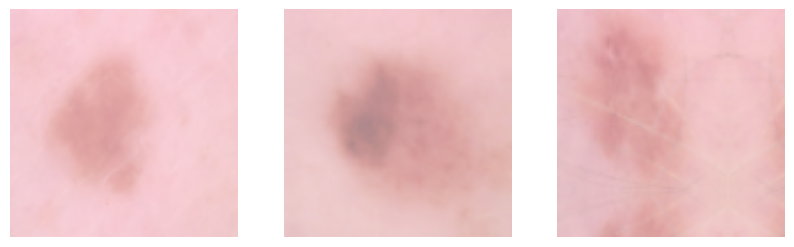

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img = ((X_train[i]/255) + 1) / 2
    plt.imshow(img)
    plt.axis('off')
plt.show()

Epoch 1/30
 10/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5495 - loss: 0.8652

W0000 00:00:1722385061.499250     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6358 - loss: 0.7136

W0000 00:00:1722385088.947453     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.6358 - loss: 0.7136 - val_accuracy: 0.7217 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7191 - loss: 0.5554 - val_accuracy: 0.7190 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7351 - loss: 0.5305 - val_accuracy: 0.7259 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7463 - loss: 0.5162 - val_accuracy: 0.7183 - val_loss: 0.5703 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7472 - loss: 0.5062 - val_accuracy: 0.7209 - val_loss: 0.5456 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7662 - loss: 0.4901 - val_accuracy: 0.7225 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7770 - loss: 0.4695

W0000 00:00:1722385259.503823     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6475 - loss: 0.6963

W0000 00:00:1722385287.101015     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - accuracy: 0.6476 - loss: 0.6962 - val_accuracy: 0.7068 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7150 - loss: 0.5641 - val_accuracy: 0.7167 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7429 - loss: 0.5190 - val_accuracy: 0.7187 - val_loss: 0.5683 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7275 - loss: 0.5337 - val_accuracy: 0.7305 - val_loss: 0.5626 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7573 - loss: 0.4934 - val_accuracy: 0.6938 - val_loss: 0.5717 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7720 - loss: 0.4875 - val_accuracy: 0.7152 - val_loss: 0.5387 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7700 - loss: 0.4770

W0000 00:00:1722385502.453058     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6446 - loss: 0.6835

W0000 00:00:1722385529.714594     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.6447 - loss: 0.6834 - val_accuracy: 0.7022 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7069 - loss: 0.5701 - val_accuracy: 0.7183 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7404 - loss: 0.5221 - val_accuracy: 0.7313 - val_loss: 0.5400 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7543 - loss: 0.4980 - val_accuracy: 0.7267 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7522 - loss: 0.5072 - val_accuracy: 0.7144 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7671 - loss: 0.4897 - val_accuracy: 0.7175 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7717 - loss: 0.4755

W0000 00:00:1722385747.716813     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6314 - loss: 0.7193

W0000 00:00:1722385774.827977     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.6314 - loss: 0.7192 - val_accuracy: 0.7026 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7147 - loss: 0.5571 - val_accuracy: 0.7206 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7372 - loss: 0.5294 - val_accuracy: 0.7156 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7643 - loss: 0.4906 - val_accuracy: 0.7252 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7642 - loss: 0.4878 - val_accuracy: 0.7294 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7689 - loss: 0.4814 - val_accuracy: 0.7294 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7743 - loss: 0.4773

W0000 00:00:1722386042.020498     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6044 - loss: 0.7423

W0000 00:00:1722386068.868270     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.6045 - loss: 0.7422 - val_accuracy: 0.7217 - val_loss: 0.5617 - learning_rate: 0.0010
Epoch 2/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.7141 - loss: 0.5607 - val_accuracy: 0.7221 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 3/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7396 - loss: 0.5205 - val_accuracy: 0.7125 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 4/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7397 - loss: 0.5162 - val_accuracy: 0.7194 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 5/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7600 - loss: 0.4952 - val_accuracy: 0.7401 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 6/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7701 - loss: 0.4835 - val_accuracy: 0.7202 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 7/30
654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7703 - loss: 0.4776

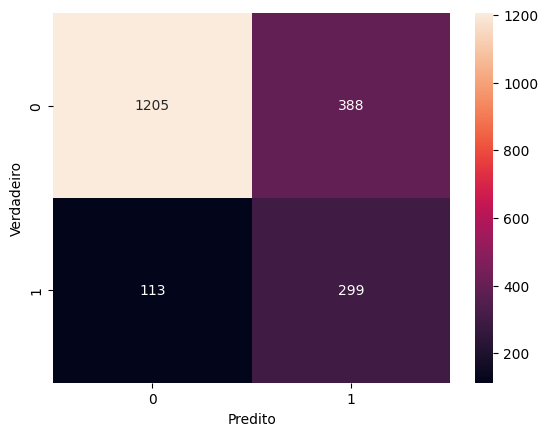

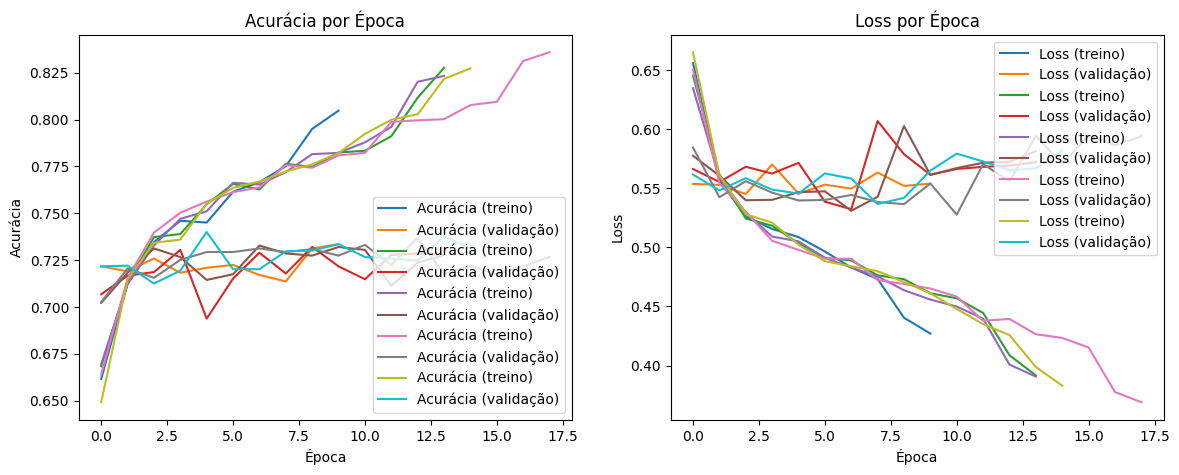

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []

for i in range(5):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, X_train, Y_train, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()